In [1]:
import numpy as np
import torch
from torch.optim import lr_scheduler
import gym
from agent import PPO
import os, shutil
from datetime import datetime
import matplotlib.pyplot as plt

### Helper functions

In [2]:
def evaluate_policy(env, model, render, steps_per_epoch):
    scores = 0
    turns = 3
    for j in range(turns):
        s, done, ep_r, steps = env.reset(), False, 0, 0
        while not (done or (steps >= steps_per_epoch)):
            # Take deterministic actions at test time
            a, logprob_a = model.evaluate(s)
            act = lambda a: 2 * (a-0.5)*env.action_space.high[0]
            s_prime, r, done, info = env.step(act(a))

            ep_r += r
            steps += 1
            s = s_prime
            if render:
                env.render()
        scores += ep_r
    return scores/turns


def plot_learning_curve(x, scores):
    running_avg = np.zeros(len(scores))
    for i in range(len(running_avg)):
        running_avg[i] = np.mean(scores[max(0, i-100):(i+1)])
    
    plt.plot(x, running_avg, label="Running average")
    plt.plot(x, scores, alpha=0.4)
    plt.title('Learning plot')
    plt.xlabel("Runs")
    plt.ylabel("Scores")
    plt.legend(loc="best")

### Main training

c:\Users\Lenovo\anaconda3\envs\myenv\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
c:\Users\Lenovo\Desktop\Python\Reinforcement Learning\5. PPO\Pytorch\Continuous\agent.py:118: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:233.)
  state = T.tensor([state], dtype=T.float)


EnvName: Pendulum-v0 steps: 0k score: -1510.5357876264686
EnvName: Pendulum-v0 steps: 5k score: -1516.6053234900107
EnvName: Pendulum-v0 steps: 10k score: -1124.9325804859964
EnvName: Pendulum-v0 steps: 15k score: -1272.5467805522965
EnvName: Pendulum-v0 steps: 20k score: -1165.1898001813893
EnvName: Pendulum-v0 steps: 25k score: -959.0153086380337
EnvName: Pendulum-v0 steps: 30k score: -1061.2824515809386
EnvName: Pendulum-v0 steps: 35k score: -1755.7756249864342
EnvName: Pendulum-v0 steps: 40k score: -1385.503116981591
EnvName: Pendulum-v0 steps: 45k score: -1291.4202984280773
EnvName: Pendulum-v0 steps: 50k score: -1200.6383257054076
EnvName: Pendulum-v0 steps: 55k score: -1371.1062192114257
EnvName: Pendulum-v0 steps: 60k score: -1264.795122534245
EnvName: Pendulum-v0 steps: 65k score: -1446.3655624072524
EnvName: Pendulum-v0 steps: 70k score: -756.269067140788
EnvName: Pendulum-v0 steps: 75k score: -825.5002796980401
EnvName: Pendulum-v0 steps: 80k score: -634.7871909905485
EnvNam

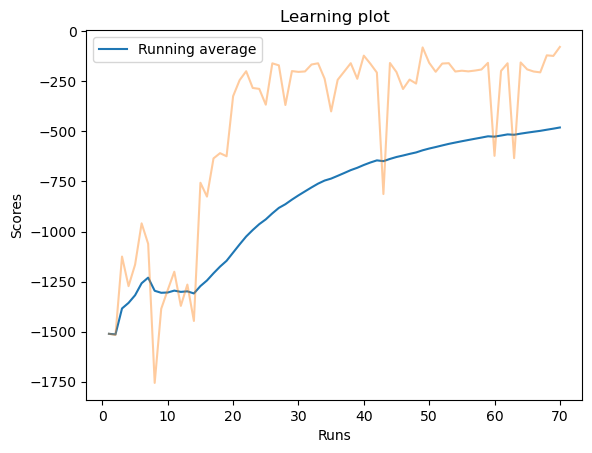

In [3]:
def main():

    # Environment
    env_id = 'Pendulum-v0'
    random_seed = 0
    torch.manual_seed(random_seed)
    np.random.seed(random_seed)
    env = gym.make(env_id)
    env.seed(random_seed)
    
    # Evaluation environment
    eval_env = gym.make(env_id)
    eval_env.seed(random_seed)
    

    # Hyperparameters
    kwargs = {
        "input_dims": env.observation_space.shape, 
        "n_actions": env.action_space.shape[0], 
        "gamma": 0.99, 
        "gae_lambda": 0.95, 
        "policy_clip": 0.2, 
        "n_epochs": 10, 
        "net_width": 256, 
        "a_lr": 3e-4, 
        "c_lr": 3e-4, 
        "l2_reg": 1e-3, 
        "dist": 'Beta',
        "batch_size": 64, 
        "entropy_coef": 0, 
        "entropy_coef_decay": 0.9998
    }

    N = 2048 # lenth of long trajectory
    max_steps = env._max_episode_steps
    Max_train_steps = 350e3
    save_interval = 50e3
    eval_interval = 5e3
    best_interval = 100e3
    render = False


    if not os.path.exists('model'): 
        os.mkdir('model')
    
    if not os.path.exists('best_model'): 
        os.mkdir('best_model')
    
    model = PPO(**kwargs)

    #scheduler = lr_scheduler.ReduceLROnPlateau(model.actor.optimizer, factor=0.1, patience=2)
    
    Loadmodel = False
    ModelIdex = 0

    if Loadmodel: 
        model.load(ModelIdex)

    traj_lenth = 0
    total_steps = 0
    score_history = []
    
    while total_steps < Max_train_steps:
        observation, done, steps, ep_r = env.reset(), False, 0, 0

        '''Interact & trian'''
        while not done:
            traj_lenth += 1
            steps += 1

            if render:
                env.render()
                action, prob = model.evaluate(observation)
            else:
                action, prob = model.select_action(observation)

            act = lambda a: 2 * (a-0.5)*env.action_space.high[0]  #Action adapter [0,1] to [-max,max]
            observation_, reward, done, info = env.step(act(action))
            model.remember(observation, observation_, action, prob, reward, done)

            observation = observation_
            ep_r += reward

            '''update if its time'''
            if not render:
                if traj_lenth % N == 0:
                    model.train()
                    traj_lenth = 0
            
            '''record & log'''
            if total_steps % eval_interval == 0:
                score = evaluate_policy(eval_env, model, False, max_steps)
                score_history.append(score)
                print('EnvName:',env_id,'steps: {}k'.format(int(total_steps/1000)),'score:', score)

            # scheduler.step(score)
            
            total_steps += 1

            '''save model'''
            if total_steps % save_interval==0:
                model.save(total_steps)
            

            ''' best model '''
            if total_steps >= best_interval:
                if score_history[-1] > score_history[-2]:
                    model.best_save()


    env.close() 
    
    x = [i+1 for i in range(len(score_history))]
    plot_learning_curve(x, score_history)

if __name__ == '__main__':
    main()

### Model testing

In [4]:
# Hyperparameters
env_id = 'Pendulum-v0'
env = gym.make(env_id)

kwargs = {
    "input_dims": env.observation_space.shape, 
    "n_actions": env.action_space.shape[0], 
    "gamma": 0.99, 
    "gae_lambda": 0.95, 
    "policy_clip": 0.2, 
    "n_epochs": 10, 
    "net_width": 256, 
    "a_lr": 3e-4, 
    "c_lr": 3e-4, 
    "l2_reg": 1e-3, 
    "dist": 'Beta',
    "batch_size": 64, 
    "entropy_coef": 0, 
    "entropy_coef_decay": 0.9998
}


model = PPO(**kwargs)

model.load_best()
scores = []


for i in range(20):
    obs = env.reset()
    actions = []
    score = 0
    while True:
        action, prob = model.evaluate(obs)
        act = lambda a: 2 * (a-0.5)*env.action_space.high[0]  #Action adapter [0,1] to [-max,max]
        obs, reward, done, info = env.step(act(action))
        score += reward
        actions.append(action)

        if done:
            print(f"Done, points: {score}")
            break
    
    scores.append(score)

print(f"Mean score: {np.mean(scores)}")



Done, points: -242.56313675807723
Done, points: -235.42871983068164
Done, points: -115.26427817429774
Done, points: -233.82101706648464
Done, points: -0.4167595770662499
Done, points: -0.3076851470608503
Done, points: -118.07283248736225
Done, points: -230.20524314178346
Done, points: -123.21296017790635
Done, points: -124.47833563067283
Done, points: -0.10334030132290828
Done, points: -228.29520729346055
Done, points: -0.2320980567349345
Done, points: -120.44011355135243
Done, points: -118.23133327082458
Done, points: -117.88784691927194
Done, points: -119.06127513763622
Done, points: -120.13474046410059
Done, points: -125.56634351548408
Done, points: -246.94993885010743
Mean score: -131.03366026758448
